# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

In [1]:
import pandas as pd
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import RandomState
from IPython.display import display
plt.style.use('seaborn-whitegrid')

<div style="border:solid purple 5px; padding: 20px"> 
<h2 align="center"> Рубрика «Питонячий лайфхакер» <a class="tocSkip"> </h2>

<h3> Широкоформатный Jupyter <a class="tocSkip"> </h3>

Расширяем границы, или как сделать работу более комфортной (не всем нравится 😄)

    from IPython.core.display import display, HTML
    display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
RANDOM_STATE=12345

## Загрузка и подготовка данных

In [3]:
try:
    df1 = pd.read_csv('geo_data_0.csv')
    df2 = pd.read_csv('geo_data_1.csv')
    df3 = pd.read_csv('geo_data_2.csv')
except:
    df1 = pd.read_csv('/datasets/geo_data_0.csv')
    df2 = pd.read_csv('/datasets/geo_data_1.csv')
    df3 = pd.read_csv('/datasets/geo_data_2.csv')

Изучим каждый регион

In [4]:
def initial_data(df):
    display(df.head())
    print('———————————————————————————————————————————————————————————————')
    print(df.info())
    print('———————————————————————————————————————————————————————————————')
    display(df.describe())
    print('———————————————————————————————————————————————————————————————')
    print(f'Количество дупликатов в столбце id: {df["id"].duplicated().sum()}')
    print('———————————————————————————————————————————————————————————————')
    print(f'Количество пропусков: \
      \n{df.isnull().sum()}')
    print('———————————————————————————————————————————————————————————————')
    sns.pairplot(data=df)
    plt.show()
    sns.heatmap(df.corr(), annot=True);
    plt.show()

——————————————————————————• Регион № 1 •——————————————————————————


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


———————————————————————————————————————————————————————————————
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
———————————————————————————————————————————————————————————————


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


———————————————————————————————————————————————————————————————
Количество дупликатов в столбце id: 10
———————————————————————————————————————————————————————————————
Количество пропусков:       
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
———————————————————————————————————————————————————————————————


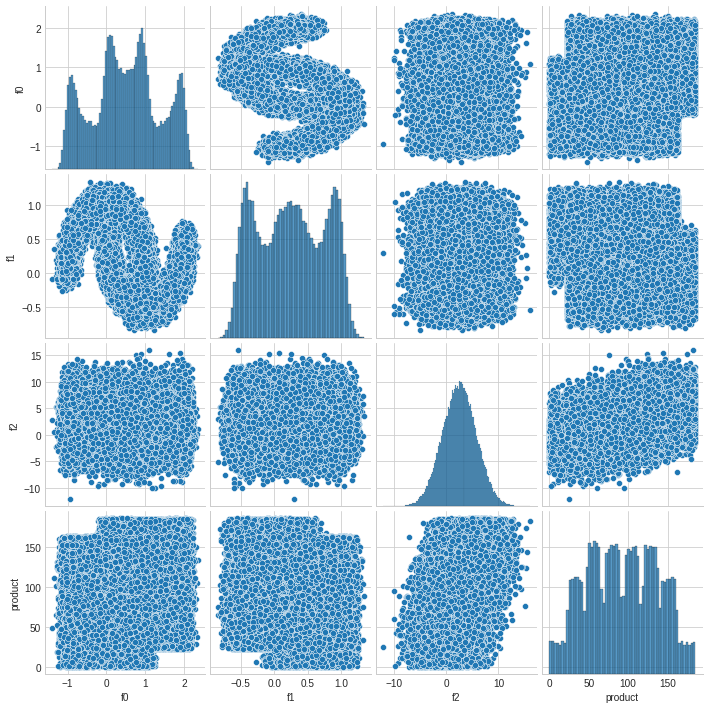

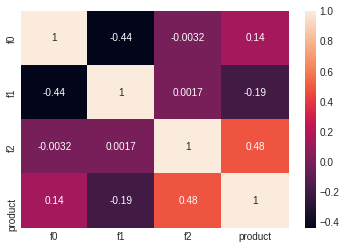

——————————————————————————• Регион № 2 •——————————————————————————


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


———————————————————————————————————————————————————————————————
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
———————————————————————————————————————————————————————————————


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


———————————————————————————————————————————————————————————————
Количество дупликатов в столбце id: 4
———————————————————————————————————————————————————————————————
Количество пропусков:       
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
———————————————————————————————————————————————————————————————


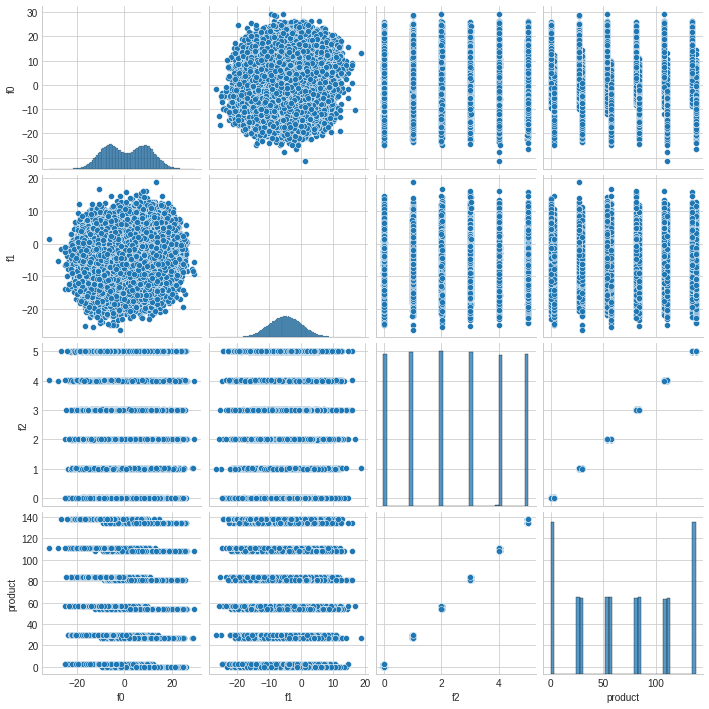

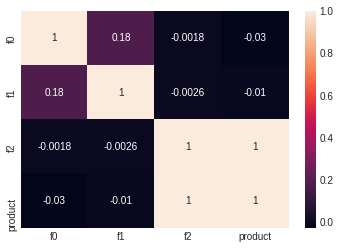

——————————————————————————• Регион № 3 •——————————————————————————


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


———————————————————————————————————————————————————————————————
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
———————————————————————————————————————————————————————————————


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


———————————————————————————————————————————————————————————————
Количество дупликатов в столбце id: 4
———————————————————————————————————————————————————————————————
Количество пропусков:       
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
———————————————————————————————————————————————————————————————


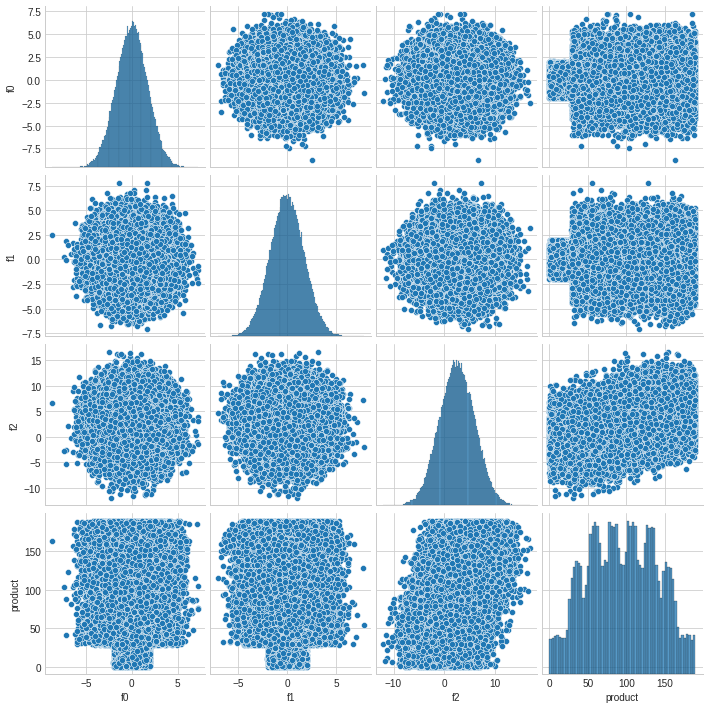

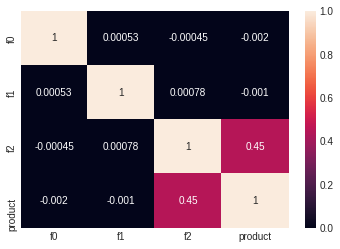

In [5]:
dict0 = {'Регион № 1': df1, 'Регион № 2': df2, 'Регион № 3': df3}
for region, df in dict0.items():
    print(f'——————————————————————————• \033[1m{region}\033[0m •——————————————————————————')
    initial_data(df)

In [6]:
for df in [df1,df2,df3]:
    df.drop_duplicates(subset = 'id', inplace=True)
    df.drop('id', axis=1, inplace=True)

**Вывод**: В исходных данных отсутствую пропуски и дубликаты. В столбце id были дупликаты, т.к. по условию id принимает уникальное значение, удалил дупликаты, оставив первое значение. Столбец id удалил, т.к. он неинформативен. Проанализировав данные, можно заметить, что они симметричны. Это связанно с тем, что данные - синтетические. Так же можно заметить зависимость между признаками f2 и product во всех регионах, причем у второго региона зависимость прямо пропорциональная.

## Обучение и проверка модели

In [7]:
dict1 = {'Регион 1': df1, 'Регион 2': df2, 'Регион 3': df3}

dict2 = {}
for region, df in dict1.items():
    features_train, features_test, target_train, target_test = train_test_split(df.iloc[:, :-1], df.iloc[:, -1], test_size=0.25, random_state=RANDOM_STATE)
    p1 = make_pipeline(StandardScaler(), LinearRegression())

    p1.fit(features_train, target_train)
    predicted = pd.Series(p1.predict(features_test), index=target_test.index)
    dict2[region] = ({'Целевое значение': target_test,'Предсказания' : predicted,'Средний запас' : predicted.mean(),
                     'RMSE модели' : mean_squared_error(target_test, predicted, squared=False)} )

In [8]:
df = pd.DataFrame.from_dict(dict2, orient='index', columns=['Средний запас', 'RMSE модели'])
df = df.rename(columns={'Средний запас': "Средний запас, тыс. баррелей", 'RMSE модели': "RMSE модели, тыс. баррелей"}).round(decimals = 2)
df

,"Средний запас, тыс. баррелей","RMSE модели, тыс. баррелей"
Регион 1,92.79,37.85
Регион 2,69.18,0.89
Регион 3,94.87,40.08


**Вывод**: Разбил данные по каждому региону на обучающую и тестовую выборки в соотношении 75:25. Создал пайплайн, где стандартизировал данные и обучил модель линейной регрессии. Получили, что лучше всего модель предсказывает данные во втором регионе, где ранее было отмечено, что зависимость между целевым признаком и одним из признаков линейная, среднеквадратичная ошибка в данном случае 0.89 тыс. баррелей. При этом в данном регионе наименьший запас углеводородов.

## Подготовка к расчёту прибыли

In [9]:
BUDGET=10**10
INCOME_PER_UNIT=450*1000
WELLS_FOR_DRILLING=200
EXPLORATORY_WELLS=500
SAMPLES_NUMBER=1000

In [10]:
breakeven_point_per_well = BUDGET/(INCOME_PER_UNIT*200)
print(f'Достаточный объём сырья для безубыточной эксплуатации новой скважины: \033[1m{breakeven_point_per_well :.2f} тыс. баррелей \033[0m')

Достаточный объём сырья для безубыточной эксплуатации новой скважины: 111.11 тыс. баррелей 


In [11]:
print(f'Процент скважин, обеспечивающих безубыточную разработку:')
for region, df in dict1.items():
    print(f'{region}: {100 - st.percentileofscore(df["product"], breakeven_point_per_well) :.2f}%')



Процент скважин, обеспечивающих безубыточную разработку:
Регион 1: 36.58%
Регион 2: 16.54%
Регион 3: 38.18%


**Вывод**: Сравнив достаточный объем сырья для безубыточной разработки скважиный со средним значением в регионе, получили, что в среднем скважины дают меньше углеводородов во всех регионах. Однако, около 36.58%, 16.5% и 38.18% от всех скважин рентабельны в 1, 2 и 3 регионах соответственно. 

## Расчёт прибыли и рисков 

In [12]:
def profit(predictions, target, count=WELLS_FOR_DRILLING, income_per_unit=INCOME_PER_UNIT):
    top_predictions=predictions.reset_index(drop=True).sort_values(ascending=False)[:count]
    sum_top_target = target.reset_index(drop=True)[top_predictions.index].sum()
    return round((sum_top_target*income_per_unit)-BUDGET)

In [13]:
print('Прибыль на 200 лучших скважинах:')
for region in dict2.keys():
    print(f'{region}: {profit(dict2[region]["Предсказания"], dict2[region]["Целевое значение"])} руб.')

Прибыль на 200 лучших скважинах:
Регион 1: 3365187238 руб.
Регион 2: 2415086697 руб.
Регион 3: 2501283853 руб.


In [14]:
def bootstrap(prediction, target):
    state = RandomState(12345)
    values = []
    for i in range(SAMPLES_NUMBER):
        target_subsample = target.sample(n=EXPLORATORY_WELLS, replace=True, random_state=state)
        probs_subsample = prediction[target_subsample.index] 
        values.append(profit(probs_subsample, target_subsample))
        
        
    values = pd.Series(values)
    upper = values.quantile(0.975)
    lower = values.quantile(0.025)
    mean = values.mean()
    risk = st.percentileofscore(values, 0)
    
    print(f'95%-й доверительный интервал: ({lower:,.2f};{upper:,.2f}) руб.')
    print(f'Средняя прибыль: {mean:,.2f} руб.')
    print(f'Риск убытков: {risk:.2f}%')
    sns.histplot(values, alpha=0.4,  element="step")
    plt.xlabel('Прибыль')
    plt.axvline(x=mean, color='b', ls='--', lw=3, label='Средняя прибыль')
    plt.axvline(x=lower, color='r', ls=':', lw=3, label='95%-й доверительный интервал')
    plt.axvline(x=upper, color='r', ls=':', lw=3)
    plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2)
    plt.show()

Риски и прибыль для каждого региона:
Регион 1:
95%-й доверительный интервал: (-142,942,739.32;890,976,833.42) руб.
Средняя прибыль: 380,613,470.01 руб.
Риск убытков: 7.70%


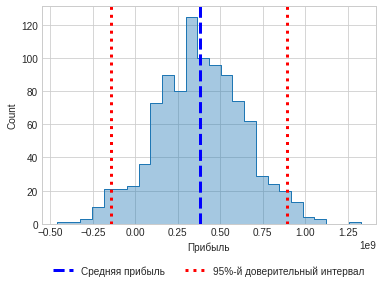

Регион 2:
95%-й доверительный интервал: (89,525,125.10;866,604,745.70) руб.
Средняя прибыль: 478,484,939.60 руб.
Риск убытков: 1.20%


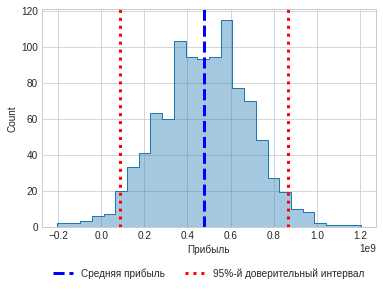

Регион 3:
95%-й доверительный интервал: (-190,365,733.40;840,467,404.10) руб.
Средняя прибыль: 330,546,258.02 руб.
Риск убытков: 11.30%


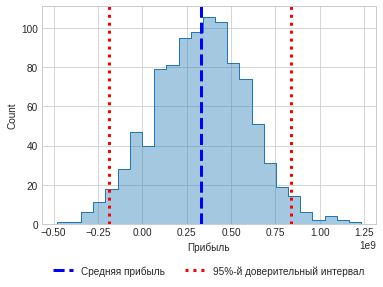

In [15]:
print('Риски и прибыль для каждого региона:')
for region in dict2.keys():
    print(f'\033[1m{region}:\033[0m')
    bootstrap(dict2[region]["Предсказания"], dict2[region]["Целевое значение"])

**Вывод**: Наиболее перспективным регионом для разработки является `Регион 2`, так как средняя прибыль в данном регионе максимальная, а риск убытков менее 1.20%.

## Вывод

1. В ходе работы мной были исследованы и подготовлены данные по трём регионам для добычи нефти: проверены дубликаты, пропуски, изучены распределения исходных признаков и зависимости между, удалены неинформативные признаки. 
2. Данные были разделены на обучающую и тестовую выборки. Был создан пайплайн, в котором я объединил операцию предварительной обработки (масштабирования данных ) с моделью машинного обучения типа линейной регрессии, для предсказания объемов добычи нефти в скважинах. Был расчитан средний запас предсказанного сырья и среднеквадратичная ошибка модели. Наиболее достоверными оказались предсказания во втором регионе.
3. Был расчитан достаточный объем сырья для безубыточной эксплуатации одной скважины (111.11 тыс. баррелей).
4. Была написана функция для расчета прибыли по 200 скважинам с максимальными предсказанными запасами.
5. Затем была выполнена процедура бутстрэпа с 1000 выборок, с помощью которого нашли распределение прибыли и проанализировали качество модели на фактических данных. Была найдена средняя прибыль, 95% доверительный интервал и риск убытков. Определено, что наиболее перспективным регионом для разработки является Регион 2, так как средняя прибыль в данном регионе максимальная (более 470 млн. руб), а риск убытков 1.20%.